## David Liu
## BAN 676

## QUESTION 1:

#### Build a CNN Classification Model to classify species from the Orchid Flowers dataset (Use train and validation data for respective purpose, no testing needed)

#### (1) Model 1: from scratch using CNN layers

In [1]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from keras_preprocessing.image import ImageDataGenerator
from tensorflow import keras
import matplotlib.pyplot as plt
from PIL import Image

print(tf.__version__)

2.0.0


## Preliminary Steps
Checking to see how many images are in the entire orchid data directory

In [2]:
# There should be 7156 images. However, since 4 images were originally jfif formatted and later re-saved as jpeg files, we have 4
# extra images, totaling 7160.
orchid_directory = "Orchid Flowers Dataset-v1.1/Orchid_Images"

file_names = os.listdir(orchid_directory)
print(len(file_names), "images")

7160 images


Putting together a dataframe that shows the image file names and their associated labels. This dataframe will be used later to build an image dataset with associated labels.

In [3]:
img_label = pd.read_csv("Orchid Flowers Dataset-v1.1/Species_Classifier/ClassLabels.txt", header=None)
img_label.columns = ["Images","Labels"]
img_label["Labels"] = img_label["Labels"].astype(str)
img_label

,Images,Labels
0,1.jpg,1
1,2.jpg,1
2,3.jpg,1
3,4.jpg,1
4,5.jpg,1
...,...,...
7151,7152.jpeg,63
7152,7153.jpeg,63
7153,7154.jpeg,63
7154,7155.jpg,63


Identifying all image files' formats in the image folder. The tensorflow functions, flow_from_dataframe() and ImageDataGenerator(), which will be used later to create an image dataset. Only accepts jpeg, png, bmp, and gif image formats.

In [4]:
file_names_df = pd.DataFrame(file_names)
file_names_df[0] = file_names_df[0].str.extract("[0-9]+.(.*)")
file_names_df_dummies = pd.get_dummies(file_names_df[0])
file_names_df_dummies.sum()

jfif       4
jpeg      34
jpg     7122
dtype: int64

Shown above, there are 4 jfif images, which not an acceptable image format. These images will be re-saved as jpeg.

In [5]:
deviant_files = []

for each in file_names:
    if each.endswith(".jfif") == True:
        deviant_files.append(each)

print(deviant_files)
  

['7069.jfif', '7068.jfif', '7067.jfif', '7071.jfif']


The 4 jfif files - '7067.jfif', '7068.jfif', '7069.jfif', and '7071.jfif' - are converted to jpg, and resaved into the image folder.

In [6]:
for each in deviant_files:
    im = Image.open(orchid_directory + "/" + each)
    im.save(orchid_directory + "/" + each.split(".")[0] + ".jpg")

The file names with the .jfif format extension in the img_label dataframe will be converted to the .jpg format extension. The strings under the "Images" column in the img_label dataframe will be used as directory names that points to an image file in the image folder. Therefore, the strings must match the image filenames in the image folder directory.  

In [7]:
for index in range(len(img_label)):
    if img_label.iloc[index,0] in deviant_files:
        img_label.iloc[index,0] = img_label.iloc[index,0].split(".")[0] + ".jpg"

Identifying all image formats in the orchid image folder again.

In [8]:
formats = img_label["Images"].str.extract("[0-9]+.(.*)")

formats_dummies = pd.get_dummies(formats[0])
formats_dummies.sum()


jpeg      34
jpg     7122
dtype: int64

Few lines from the img_label dataframe

In [9]:
img_label.head(20)

,Images,Labels
0,1.jpg,1
1,2.jpg,1
2,3.jpg,1
3,4.jpg,1
4,5.jpg,1
5,6.jpg,1
6,7.jpg,1
7,8.jpg,1
8,9.jpg,1
9,10.jpg,1


## Split Training/Validation Data

Extracting the data again, and splitting them into training and validation data. Extracted images are resized to 256 x 256. The number of classes shown in the outputs below are inferred by the image_data.flow_from_dataframe() function. 

In [10]:
image_data=ImageDataGenerator(rescale=1./255.,validation_split=0.3)

In [11]:
orchid_img_train = image_data.flow_from_dataframe(
    dataframe=img_label,
    directory = "Orchid Flowers Dataset-v1.1/Orchid_Images/",
    subset = "training",
    x_col = "Images",
    y_col = "Labels",
    batch_size = 32,
    seed = 2,
    shuffle = False,
    class_mode = "categorical",
    target_size = (256,256),
)

Found 5010 validated image filenames belonging to 156 classes.


In [12]:
orchid_img_val = image_data.flow_from_dataframe(
    dataframe=img_label,
    directory = "Orchid Flowers Dataset-v1.1/Orchid_Images/",
    subset = "validation",
    x_col = "Images",
    y_col = "Labels",
    batch_size = 32,
    seed = 2,
    shuffle = False,
    class_mode = "categorical",
    target_size = (256,256),
)

Found 2146 validated image filenames belonging to 156 classes.


Displaying some images from the training and validation datasets. The purpose of this is to get an idea of what the images look like, and to determine whether there might be possible issues as a result of the images being resized.

Training Data

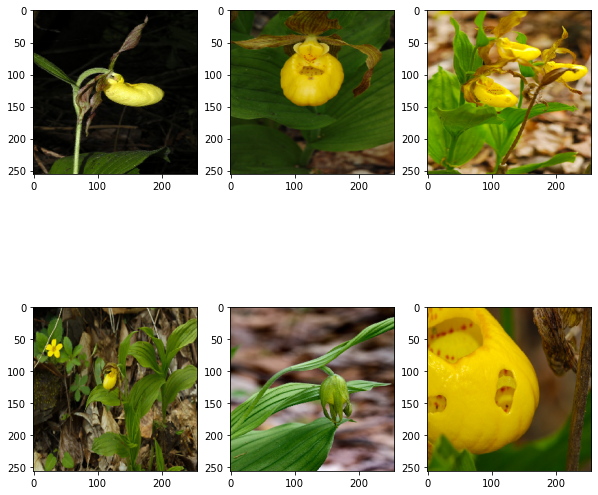

In [13]:
x,y = orchid_img_train.next()

plt.figure(figsize=(10,10))

for each in range(6):
    plt.subplot(2,3, each+1)
    image = x[each]
    plt.imshow(image)

Validation Data

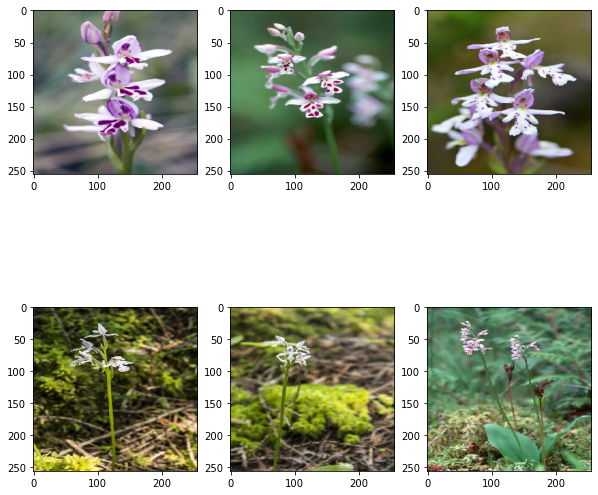

In [14]:
#help(orchid_img_val)
x,y = orchid_img_val.next()

plt.figure(figsize=(10,10))

for each in range(6):
    plt.subplot(2,3, each+1)
    image = x[each]
    plt.imshow(image)

## Building the Model

Creating the CNN model

In [35]:
orchid_model = keras.Sequential()
orchid_model.add(keras.layers.Conv2D(32, (3, 3), padding='same', input_shape=(256,256,3)))
orchid_model.add(keras.layers.Activation('relu'))
orchid_model.add(keras.layers.Conv2D(24, (3, 3)))
orchid_model.add(keras.layers.Activation('relu'))
orchid_model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
orchid_model.add(keras.layers.Dropout(0.25))

orchid_model.add(keras.layers.Conv2D(24, (3, 3), padding='same'))
orchid_model.add(keras.layers.Activation('relu'))
orchid_model.add(keras.layers.Conv2D(16, (3, 3)))
orchid_model.add(keras.layers.Activation('relu'))
orchid_model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
orchid_model.add(keras.layers.Dropout(0.25))

orchid_model.add(keras.layers.Flatten())
orchid_model.add(keras.layers.Dense(512))
orchid_model.add(keras.layers.Activation('relu'))
orchid_model.add(keras.layers.Dropout(0.5))

orchid_model.add(keras.layers.Dense(156, activation='softmax'))
orchid_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

Reset the model, if needed

In [36]:
orchid_model.reset_states()
tf.keras.backend.clear_session()

In [37]:
orchid_model.compile(optimizer=keras.optimizers.Adam(lr=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [38]:
train_step = orchid_img_train.n//orchid_img_train.batch_size
val_step = orchid_img_val.n//orchid_img_val.batch_size

history = orchid_model.fit_generator(generator = orchid_img_train, 
                                     steps_per_epoch = train_step,
                                     validation_data = orchid_img_val, 
                                     validation_steps = val_step,
                                     epochs=10)

Epoch 1/10
156/156 [==============================] - 772s 5s/step - loss: 5.0211 - accuracy: 0.0323 - val_loss: 5.0803 - val_accuracy: 0.0602
Epoch 2/10
156/156 [==============================] - 762s 5s/step - loss: 4.7728 - accuracy: 0.0392 - val_loss: 5.2556 - val_accuracy: 0.0676
Epoch 3/10
156/156 [==============================] - 761s 5s/step - loss: 4.5912 - accuracy: 0.0418 - val_loss: 5.3843 - val_accuracy: 0.0676
Epoch 4/10
156/156 [==============================] - 759s 5s/step - loss: 4.4864 - accuracy: 0.0488 - val_loss: 5.7163 - val_accuracy: 0.0625
Epoch 5/10
156/156 [==============================] - 758s 5s/step - loss: 4.3874 - accuracy: 0.0603 - val_loss: 5.7798 - val_accuracy: 0.0672
Epoch 6/10
156/156 [==============================] - 758s 5s/step - loss: 4.3044 - accuracy: 0.0733 - val_loss: 5.9461 - val_accuracy: 0.0639
Epoch 7/10
156/156 [==============================] - 879s 6s/step - loss: 4.2035 - accuracy: 0.0856 - val_loss: 6.3291 - val_accuracy: 0.0555

In [39]:
orchid_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 256, 256, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 254, 254, 24)      6936      
_________________________________________________________________
activation_1 (Activation)    (None, 254, 254, 24)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 24)      0         
_________________________________________________________________
dropout (Dropout)            (None, 127, 127, 24)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 127, 127, 24)      5

Calculating the naive model accuracy. This is a categorical problem. In order to find a decent baseline accuracy for which the CNN model must exceed, we will find the proportion of the category with the highest rate of occurrence. The highest proportion will be used as the baseline accuracy.  

In [40]:
total = img_label["Images"].count()

max_prob_category = img_label.groupby(["Labels"]).agg("count").reset_index()

max_prob_category = max(max_prob_category["Images"])

baseline_acc = max_prob_category/total

baseline_acc

0.052124091671324764

Plotting the training and validation prediction accuracy over epochs

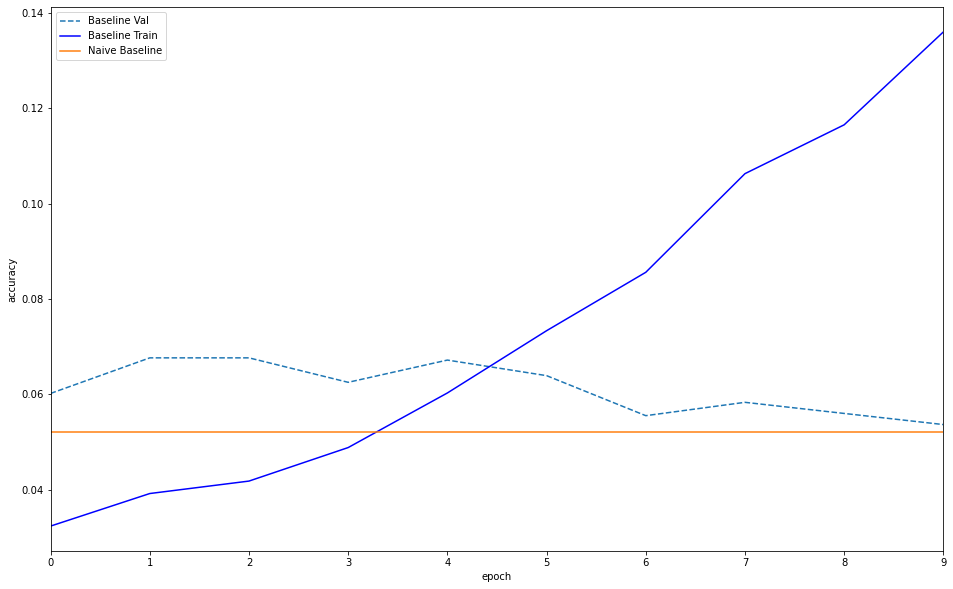

In [46]:
plt.figure(figsize=(16,10))
plt.plot(history.epoch, history.history['val_accuracy'],'--', label='Baseline Val')
plt.plot(history.epoch, history.history['accuracy'], color='blue', label='Baseline Train')
plt.plot([0,10], [baseline_acc, baseline_acc], label = 'Naive Baseline')
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.xlim([0,max(history.epoch)])
plt.legend()
plt.show()

## Final Analysis:

1)	The CNN model uses 4 convolution layers, with 32, 24, 24, and 16 outputs, respectively, a dense layer with 512 nodes, and an output layer with 156 outputs. Three dropout functions were inserted after the second and fourth convolution layer, and one after the flattened dense layer to ease overfitting.  All layers in the model uses ReLu, with the exception of the final output layer, which uses softmax. The output layer outputs 156 values, representing 1 of 156 different orchid categories. Finally, each image that goes through the model is sized 256x256 pixels. As shown by the graph above, the CNN model performed better than the 0.052, or 5.2% accuracy, baseline by the end of the 10th epoch, with a training data prediction accuracy of 0.1360 and a validation prediction accuracy of 0.0536. It should be noted that the validation accuracy showed little change while the testing accuracy continued to increase, suggesting that the model may be overfitting or that the validation data is not training very well. However, the training data accuracy is shown to be increasing with each model fitting iteration, implying that the model may still have the potential to become more accurate given more epochs. As it is, the model would not be very practical for orchid classification becaues the accuracy rates are objectively low.